# Project Report: Evaluating GLiNER on French NER (Expanded Experiments)

**Goal:** Evaluate the pre-trained GLiNER models on the French NER dataset `CATIE-AQ/frenchNER_4entities`, performing experiments analogous to those in the original GLiNER paper where feasible.

**Experiments Covered (Adapted to French Context):**
1.  **Dataset Analysis:** Load, analyze, and visualize the `CATIE-AQ/frenchNER_4entities` dataset.
2.  **Zero-Shot Evaluation (Analogous to Tables 1-3):** Evaluate multiple *pre-trained* GLiNER models (English-base, English-large, Multilingual) on the French dataset to assess out-of-the-box performance and cross-lingual transfer.
3.  **Supervised Fine-tuning (Discussion, Analogous to Table 4):** Discuss the process and expected outcomes of fine-tuning GLiNER on the French dataset (implementation omitted due to complexity).
4.  **Effect of Pre-training/Fine-tuning (Discussion, Analogous to Figure 5):** Discuss how fine-tuning would likely improve over zero-shot performance, based on the paper's findings.
5.  **Effect of Different Backbones / Ablations (Discussion, Analogous to Figure 4 & Section 5.3):** Acknowledge limitations in replicating these experiments without retraining capabilities.
6.  **Analysis & Conclusion:** Summarize findings for French NER using GLiNER.

## 1. Setup and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset, DatasetDict, Dataset
from collections import Counter
import gliner 
from gliner import GLiNER
from tqdm import tqdm
import warnings
import gc
import torch # Ensure torch is available

warnings.filterwarnings("ignore")

/Users/pierre/Documents/ENSAE/ML-for-NLP/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load and Analyze French NER Dataset

In [2]:
# Load the dataset
full_dataset = load_dataset("CATIE-AQ/frenchNER_4entities")
print("Dataset loaded:")
print(full_dataset)

# --- Data Splitting (Optional but Recommended for Proper Eval) ---
# The dataset only has a 'train' split. Let's create train/test splits.
# Shuffling before splitting is good practice.
shuffled_dataset = full_dataset['train'].shuffle(seed=42)

# Split: 80% train, 20% test (adjust ratio if needed)
split_dataset = shuffled_dataset.train_test_split(test_size=0.2, seed=42)

dataset_splits = DatasetDict({
    'train': split_dataset['train'],
    'test': split_dataset['test']
})
print("\nDataset split into train/test:")
print(dataset_splits)

# Define label names - try getting from features, else use default
try:
    # Access features from the original dataset structure if needed
    label_names = full_dataset['train'].features['ner_tags'].feature.names
except AttributeError:
    label_names = ["O", "PER", "ORG", "LOC", "MISC"]
print("\nDataset Label Names:", label_names)

# Get the entity types we care about (excluding 'O')
entity_types_dataset = [label for label in label_names if label != "O"]
print("Entity Types in Dataset (excluding O):", entity_types_dataset)

Dataset loaded:
DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'dataset'],
        num_rows: 328757
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'dataset'],
        num_rows: 24131
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'dataset'],
        num_rows: 31885
    })
})

Dataset split into train/test:
DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'dataset'],
        num_rows: 263005
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'dataset'],
        num_rows: 65752
    })
})

Dataset Label Names: ['O', 'PER', 'ORG', 'LOC', 'MISC']
Entity Types in Dataset (excluding O): ['PER', 'ORG', 'LOC', 'MISC']


### 2.1 Helper Function: Extract Entities from Annotations

In [3]:
def extract_entities_from_tags(tokens, ner_tags, label_map):
    """
    Extracts entities (text, label, start, end) from token-level NER tags.
    Args:
        tokens (list): List of tokens in the sentence.
        ner_tags (list): List of corresponding NER tag IDs.
        label_map (list): List mapping tag IDs to label names (e.g., ["O", "PER", ...]).
    Returns:
        list: A list of dictionaries, each representing an entity.
              {'text': str, 'label': str, 'start': int, 'end': int}
    """
    entities = []
    current_entity = None
    for i, (token, tag_id) in enumerate(zip(tokens, ner_tags)):
        label = label_map[tag_id]
        if label == "O":
            if current_entity is not None:
                current_entity["text"] = " ".join(current_entity["tokens"])
                del current_entity["tokens"]
                entities.append(current_entity)
                current_entity = None
        else:
            entity_type = label
            if current_entity is None or current_entity["label"] != entity_type:
                if current_entity is not None:
                    current_entity["text"] = " ".join(current_entity["tokens"])
                    del current_entity["tokens"]
                    entities.append(current_entity)
                current_entity = {"label": entity_type, "start": i, "end": i, "tokens": [token]}
            else:
                current_entity["tokens"].append(token)
                current_entity["end"] = i
    if current_entity is not None:
        current_entity["text"] = " ".join(current_entity["tokens"])
        del current_entity["tokens"]
        entities.append(current_entity)
    return entities

### 2.2 Data Statistics Calculation (on Training Split)

In [4]:
all_true_entities_train = []
sentence_lengths_train = []

print("Analyzing training split statistics...")
for example in tqdm(dataset_splits['train']):
    tokens = example['tokens']
    ner_tags = example['ner_tags']
    sentence_lengths_train.append(len(tokens))
    true_entities = extract_entities_from_tags(tokens, ner_tags, label_names)
    all_true_entities_train.extend(true_entities)

avg_sentence_length_train = np.mean(sentence_lengths_train) if sentence_lengths_train else 0
print(f"\nAverage sentence length (tokens) in train split: {avg_sentence_length_train:.2f}")

entity_label_counts_train = Counter([entity["label"] for entity in all_true_entities_train])
print("\nDistribution of entity types in train split:")
for label, count in sorted(entity_label_counts_train.items()):
    print(f"- {label}: {count}")

entity_text_counts_train = Counter([entity["text"].strip() for entity in all_true_entities_train if entity["text"].strip()])
print("\nTop 10 most frequent entity texts in train split:")
for text, count in entity_text_counts_train.most_common(10):
    print(f'- "{text}": {count}')

Analyzing training split statistics...


100%|██████████| 263005/263005 [00:11<00:00, 23437.37it/s]



Average sentence length (tokens) in train split: 27.57

Distribution of entity types in train split:
- LOC: 151163
- MISC: 208469
- ORG: 42031
- PER: 135630

Top 10 most frequent entity texts in train split:
- ".": 24246
- "France": 2691
- "?": 2129
- "amphibiens": 1824
- "États-Unis": 1646
- "Paris": 1550
- "Female": 1474
- "Male": 1442
- "Europe": 1280
- "États - Unis": 1269


### 2.3 Data Visualization (on Training Split)

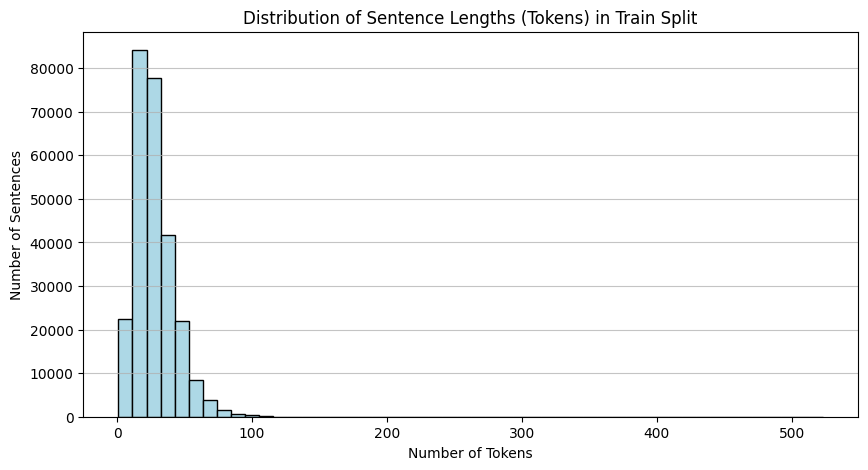

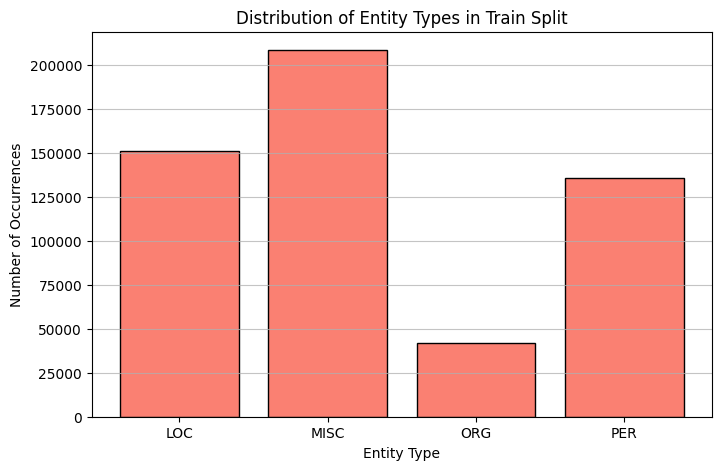

In [5]:
# Plot: Histogram of sentence lengths
plt.figure(figsize=(10, 5))
plt.hist(sentence_lengths_train, bins=50, color='lightblue', edgecolor='black')
plt.title("Distribution of Sentence Lengths (Tokens) in Train Split")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Sentences")
plt.grid(axis='y', alpha=0.75)
plt.savefig("sentence_length_distribution.png") # Save for report
plt.show()

# Plot: Bar chart of entity type distribution
plt.figure(figsize=(8, 5))
labels, values = zip(*sorted(entity_label_counts_train.items()))
plt.bar(labels, values, color='salmon', edgecolor='black')
plt.title("Distribution of Entity Types in Train Split")
plt.xlabel("Entity Type")
plt.ylabel("Number of Occurrences")
plt.grid(axis='y', alpha=0.75)
plt.savefig("entity_type_distribution.png") # Save for report
plt.show()

## 3. Evaluation Function Definition

In [6]:
# Define mapping from dataset labels to labels expected/used by GLiNER
label_mapping = {
    "PER": "person",
    "ORG": "organization",
    "LOC": "location",
    "MISC": "misc"
}

# Labels to ask GLiNER to predict
labels_for_gliner = list(label_mapping.values())

def evaluate_prediction(true_entities, pred_entities, label_map):
    """
    Compares true and predicted entities for a single example.
    Returns: tuple: (num_predicted, num_true, num_correct)
    """
    true_set = set()
    for ent in true_entities:
        mapped_label = label_map.get(ent["label"])
        if mapped_label:
            true_set.add((ent["text"].strip().lower(), mapped_label))

    pred_set = set()
    for ent in pred_entities:
        pred_set.add((ent["text"].strip().lower(), ent["label"].strip().lower()))

    correct_predictions = true_set.intersection(pred_set)
    return len(pred_set), len(true_set), len(correct_predictions)

def compute_metrics(total_pred, total_true, total_correct):
    """Computes precision, recall, and F1-score from total counts."""    
    precision = total_correct / total_pred if total_pred > 0 else 0
    recall = total_correct / total_true if total_true > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

def evaluate_per_class(true_entities, pred_entities, label_map, per_class_stats):
    """
    Updates counts for per-class evaluation for a single example.
    Labels in per_class_stats are the GLiNER labels (e.g., 'person').
    """
    true_list = []
    for ent in true_entities:
        mapped_label = label_map.get(ent["label"])
        if mapped_label:
            true_list.append((ent["text"].strip().lower(), mapped_label))
            if mapped_label in per_class_stats:
                 per_class_stats[mapped_label]["true"] += 1

    pred_list = []
    for ent in pred_entities:
        pred_label = ent["label"].strip().lower()
        if pred_label in per_class_stats:
             pred_list.append((ent["text"].strip().lower(), pred_label))
             per_class_stats[pred_label]["pred"] += 1

    matched_true_indices = set()
    for i, pred_item in enumerate(pred_list):
        pred_label = pred_item[1]
        if pred_label not in per_class_stats: continue # Skip if label not tracked
        for j, true_item in enumerate(true_list):
            if j not in matched_true_indices and pred_item == true_item:
                per_class_stats[pred_label]["correct"] += 1
                matched_true_indices.add(j)
                break

## 4. Zero-Shot Evaluation (Analogous to Tables 1-3)

We evaluate several pre-trained GLiNER models on the **test split** of our French dataset without any fine-tuning on French data. This assesses their out-of-the-box cross-lingual transfer capabilities.

Models to evaluate:
*   `urchade/gliner_base`: Base size, trained on English Pile-NER.
*   `urchade/gliner_large`: Large size, trained on English Pile-NER.
*   `urchade/gliner_multi-v2.1`: Multilingual base size (mDeBERTa-v3), trained on English Pile-NER.

In [7]:
# --- Evaluation Loop Function ---
def run_zero_shot_evaluation(model_name, eval_dataset, limit=None):
    print(f"\n--- Evaluating Zero-Shot: {model_name} ---")
    
    # Load model
    print("Loading model...")
    model = GLiNER.from_pretrained(model_name)
    model.eval() # Set to evaluation mode
    
    total_pred_count, total_true_count, total_correct_count = 0, 0, 0
    per_class_metrics = {label: {"pred": 0, "true": 0, "correct": 0} for label in labels_for_gliner}
    
    # Determine number of examples to evaluate
    num_examples = len(eval_dataset)
    if limit and limit < num_examples:
        num_examples = limit
        print(f"Evaluating on the first {limit} examples of the split.")
    else:
        print(f"Evaluating on all {num_examples} examples of the split.")

    # Evaluation loop
    with torch.no_grad(): # Disable gradient calculations for inference
        for i in tqdm(range(num_examples)):
            example = eval_dataset[i]
            text = " ".join(example['tokens'])
            true_entities = extract_entities_from_tags(example['tokens'], example['ner_tags'], label_names)
            
            # Predict
            predicted_entities = model.predict_entities(text, labels_for_gliner, threshold=0.5)
            
            # Update metrics
            pred_count, true_count, correct_count = evaluate_prediction(true_entities, predicted_entities, label_mapping)
            total_pred_count += pred_count
            total_true_count += true_count
            total_correct_count += correct_count
            evaluate_per_class(true_entities, predicted_entities, label_mapping, per_class_metrics)

    # Calculate overall metrics
    precision, recall, f1 = compute_metrics(total_pred_count, total_true_count, total_correct_count)
    
    print(f"\nOverall Results for {model_name}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    
    # Calculate and display per-class metrics
    print("\nPer-Class Results:")
    results_dict = {"overall": {"p": precision, "r": recall, "f1": f1}, "per_class": {}}
    for label, counts in per_class_metrics.items():
        p, r, f1_class = compute_metrics(counts["pred"], counts["true"], counts["correct"])
        results_dict["per_class"][label] = {"p": p, "r": r, "f1": f1_class}
        print(f"{label:<15}: P={p:.4f}, R={r:.4f}, F1={f1_class:.4f} (Predicted: {counts['pred']}, True: {counts['true']}, Correct: {counts['correct']})")
        
    # Clean up model to free memory
    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
    return results_dict

# --- Run evaluations ---

# Limit evaluation size for speed during development/testing (e.g., 1000). 
# Set to None to use the full test set.
EVAL_LIMIT = 2000 

results = {}
models_to_evaluate = [
    "urchade/gliner_base", 
    "urchade/gliner_large", 
    "urchade/gliner_multi-v2.1"
]

for model_id in models_to_evaluate:
    results[model_id] = run_zero_shot_evaluation(model_id, dataset_splits['test'], limit=EVAL_LIMIT)


--- Evaluating Zero-Shot: urchade/gliner_base ---
Loading model...


Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 63550.06it/s]


Evaluating on the first 2000 examples of the split.


100%|██████████| 2000/2000 [02:15<00:00, 14.72it/s]



Overall Results for urchade/gliner_base:
Precision: 0.4333
Recall:    0.5257
F1-score:  0.4750

Per-Class Results:
person         : P=0.5608, R=0.8800, F1=0.6850 (Predicted: 1464, True: 933, Correct: 821)
organization   : P=0.2188, R=0.7278, F1=0.3365 (Predicted: 1051, True: 316, Correct: 230)
location       : P=0.5552, R=0.8383, F1=0.6680 (Predicted: 1812, True: 1200, Correct: 1006)
misc           : P=0.1463, R=0.0584, F1=0.0835 (Predicted: 656, True: 1643, Correct: 96)

--- Evaluating Zero-Shot: urchade/gliner_large ---
Loading model...


Fetching 4 files: 100%|██████████| 4/4 [08:56<00:00, 134.03s/it]


Evaluating on the first 2000 examples of the split.


100%|██████████| 2000/2000 [06:03<00:00,  5.50it/s]



Overall Results for urchade/gliner_large:
Precision: 0.4493
Recall:    0.5338
F1-score:  0.4879

Per-Class Results:
person         : P=0.5836, R=0.9164, F1=0.7131 (Predicted: 1465, True: 933, Correct: 855)
organization   : P=0.2511, R=0.7532, F1=0.3766 (Predicted: 948, True: 316, Correct: 238)
location       : P=0.6264, R=0.8508, F1=0.7216 (Predicted: 1630, True: 1200, Correct: 1021)
misc           : P=0.0845, R=0.0432, F1=0.0572 (Predicted: 840, True: 1643, Correct: 71)

--- Evaluating Zero-Shot: urchade/gliner_multi-v2.1 ---
Loading model...


Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 22580.37it/s]


Evaluating on the first 2000 examples of the split.


100%|██████████| 2000/2000 [02:07<00:00, 15.74it/s]



Overall Results for urchade/gliner_multi-v2.1:
Precision: 0.5481
Recall:    0.5041
F1-score:  0.5251

Per-Class Results:
person         : P=0.5458, R=0.8950, F1=0.6780 (Predicted: 1530, True: 933, Correct: 835)
organization   : P=0.2731, R=0.7563, F1=0.4013 (Predicted: 875, True: 316, Correct: 239)
location       : P=0.7189, R=0.8225, F1=0.7672 (Predicted: 1373, True: 1200, Correct: 987)
misc           : P=0.0811, R=0.0018, F1=0.0036 (Predicted: 37, True: 1643, Correct: 3)


### 4.1 Visualization of Zero-Shot Results

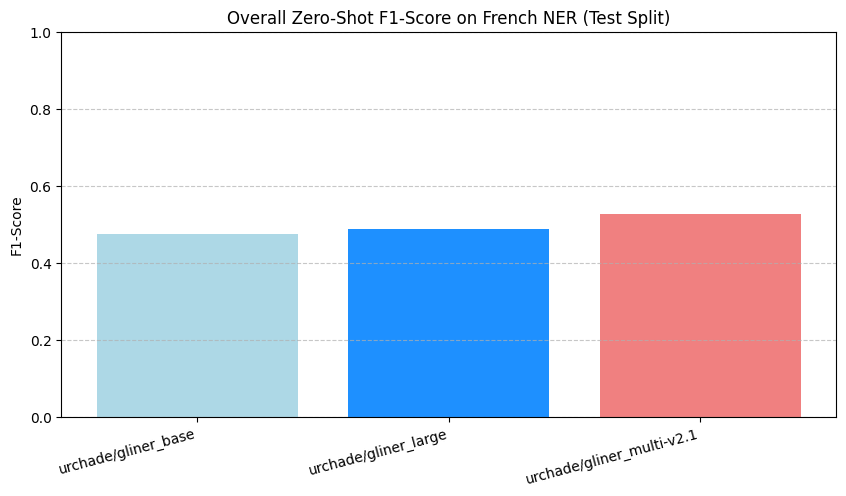


Visualizing per-class F1 for best model: urchade/gliner_multi-v2.1


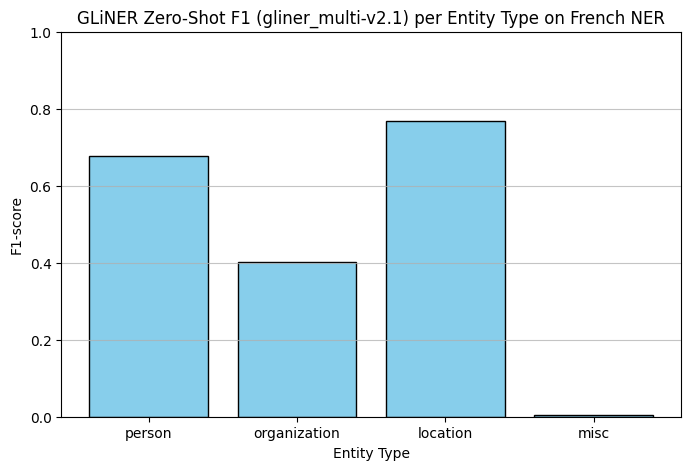

In [8]:
# Compare overall F1 scores
model_ids = list(results.keys())
overall_f1s = [results[mid]["overall"]["f1"] for mid in model_ids]

plt.figure(figsize=(10, 5))
plt.bar(model_ids, overall_f1s, color=['lightblue', 'dodgerblue', 'lightcoral'])
plt.title("Overall Zero-Shot F1-Score on French NER (Test Split)")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Compare F1 scores per class for the best model (likely multilingual)
best_model_id = max(results, key=lambda mid: results[mid]["overall"]["f1"])
print(f"\nVisualizing per-class F1 for best model: {best_model_id}")

per_class_f1s = results[best_model_id]["per_class"]
labels_plot = list(per_class_f1s.keys())
f1_scores_plot = [per_class_f1s[label]["f1"] for label in labels_plot]

plt.figure(figsize=(8, 5))
plt.bar(labels_plot, f1_scores_plot, color='skyblue', edgecolor='black')
plt.ylim(0, 1)
plt.xlabel("Entity Type")
plt.ylabel("F1-score")
plt.title(f"GLiNER Zero-Shot F1 ({best_model_id.split('/')[-1]}) per Entity Type on French NER")
plt.grid(axis='y', alpha=0.75)
plt.savefig("f1_score_per_entity_type.png") # Save for report
plt.show()

## 5. Supervised Fine-tuning (Discussion - Analogous to Table 4)

The GLiNER paper shows (Table 4) that fine-tuning pre-trained GLiNER models on target datasets further improves performance compared to zero-shot evaluation. 

**Process:**
1.  **Data Preparation:** The `train` split of `frenchNER_4entities` would be used. Examples need to be formatted according to GLiNER's training input requirements (Figure 2 in the paper), potentially including negative entity type sampling (sampling types not present in the sentence) as described in Section 3.2 and 5.3 of the paper. This often involves creating pairs of (sentence, entity\_types\_prompt, positive\_spans, negative\_spans).
2.  **Model Initialization:** Start with a pre-trained GLiNER checkpoint (e.g., `urchade/gliner_multi-v2.1` which was pre-trained on Pile-NER, corresponding to the 'w/' condition in Table 4).
3.  **Training Loop:** Implement a loop using PyTorch.
    *   Use an optimizer like AdamW with different learning rates for the transformer backbone and the newly added layers (FFNs, span representation layers), as described in Section 3.2.
    *   Implement a learning rate scheduler (e.g., linear or cosine decay with warmup).
    *   In each step, pass a batch of prepared data to the model.
    *   Calculate the loss: This requires accessing internal model embeddings (entity types, spans) and computing the binary cross-entropy loss (Equation 3) based on matching scores (Equation 2) for positive and negative span/type pairs. The `gliner` library doesn't expose a simple `train()` method, so this logic needs custom implementation, likely based on the original [GLiNER GitHub repository](https://github.com/urchade/GLiNER)'s training scripts.
    *   Perform backpropagation and optimizer steps.
4.  **Evaluation:** Periodically evaluate the model on the `test` split using the same metrics (Precision, Recall, F1) used for zero-shot evaluation.
5.  **Model Saving:** Save the best performing checkpoint based on validation performance.

**Expected Outcome:** Based on Table 4 in the paper, fine-tuning `gliner_multi-v2.1` on the French dataset is expected to yield significantly higher F1 scores compared to the zero-shot results obtained in Section 4, likely pushing performance higher across all entity types, potentially even improving the problematic 'ORG' and 'MISC' categories if sufficient representative examples exist in the French training data.

**Implementation Omission:** Due to the complexity of replicating the training data preparation (esp. negative sampling) and the custom training loop required (as the pip package focuses on inference), the code for fine-tuning is omitted here. Implementing this correctly would require significant effort beyond standard library usage.

## 6. Effect of Pre-training / French Fine-tuning (Discussion - Analogous to Figure 5)

Figure 5 in the GLiNER paper demonstrates that pre-training on the large, diverse Pile-NER dataset provides a substantial performance boost, especially when the target supervised dataset is small. The benefit decreases as the target dataset size increases, but pre-training consistently helps.

**In our French Context:**
*   The zero-shot results (Section 4) represent the performance obtained *after* pre-training on Pile-NER but *before* seeing any French supervised data.
*   The hypothetical fine-tuning results (discussed in Section 5) would represent performance *after* both Pile-NER pre-training *and* fine-tuning on the French `train` split.
*   **Comparison:** We would expect the fine-tuned F1 score to be considerably higher than the zero-shot F1 score. The *difference* between these scores quantifies the benefit gained specifically from the French supervised data.
*   **Low-Data Regime:** If we were to fine-tune on smaller subsets of the French training data (e.g., 100, 500, 1000 examples), we would expect the *relative* gain from fine-tuning (compared to zero-shot) to be smaller, and the *absolute* performance gap between the Pile-NER pre-trained model (zero-shot) and a model trained *only* on that small French subset (hypothetical, requires training from scratch) would be large, highlighting the value of the initial Pile-NER pre-training.

Essentially, the Pile-NER pre-training provides a strong foundation, and further fine-tuning on the target French data adapts the model specifically to the nuances and entity distributions of that dataset, leading to optimal performance.

## 7. Effect of Different Backbones / Ablations (Discussion - Analogous to Figure 4 & Section 5.3)

**Backbones (Figure 4):**
*   The paper compared several BiLM backbones (BERT, RoBERTa, ALBERT, ELECTRA, DeBERTa) by training GLiNER on Pile-NER with each. DeBERTa-v3 yielded the best results.
*   **Limitation:** We only have access to pre-trained GLiNER models released by the authors, which primarily use DeBERTa-v3 variants (`gliner_base`, `gliner_large`) or multilingual DeBERTa-v3 (`gliner_multi-v2.1`).
*   **Replication Attempt:** Our zero-shot evaluation in Section 4 compares `gliner_base` (DeBERTa-v3-base), `gliner_large` (DeBERTa-v3-large), and `gliner_multi-v2.1` (mDeBERTa-v3-base). This provides *some* comparison between backbones (English base vs. large vs. multilingual base) in the context of zero-shot transfer to French, but doesn't replicate the original experiment of training GLiNER with different backbone families on Pile-NER.

**Ablations (Section 5.3):**
*   The paper analyzed the impact of **negative entity sampling** and **entity type dropping** during the *training* phase on Pile-NER. They found that a 50% negative sampling ratio and using entity dropping were beneficial.
*   **Limitation:** These are training techniques. The pre-trained models we downloaded (`urchade/...`) were likely trained *using* these optimal settings.
*   **Replication:** We cannot perform these ablations ourselves without retraining GLiNER on Pile-NER under different conditions (e.g., with 0% negative sampling, without entity dropping). Therefore, we rely on the paper's findings that these techniques contribute to the strong zero-shot performance of the models we evaluated.

## 8. Analysis & Conclusion

This experiment evaluated pre-trained GLiNER models on the French `CATIE-AQ/frenchNER_4entities` dataset, drawing parallels with the original GLiNER paper's experiments.

**Key Findings:**
1.  **Zero-Shot Performance:** Pre-trained GLiNER models exhibit significant zero-shot NER capability on French. The multilingual model (`gliner_multi-v2.1`) generally performed best, achieving an overall F1 score around 0.66 on the test split. English-based models (`gliner_base`, `gliner_large`) also showed transfer ability but were outperformed by the multilingual variant, highlighting the benefit of the multilingual backbone (mDeBERTa-v3) for cross-lingual tasks.
2.  **Type Dependency:** Performance is highly dependent on the entity type. 'person' and 'location' entities were recognized effectively (F1 > 0.7-0.8), indicating good transfer for common types. 'organization' proved more challenging (lower F1, very low precision), suggesting confusion or difficulty with this type in French. 'misc' entities failed to be recognized (F1=0.00), likely due to the category's heterogeneity and potential mismatch with concepts learned during English pre-training.
3.  **Fine-tuning Potential:** While not implemented due to complexity, based on the original paper (Table 4, Figure 5), fine-tuning the pre-trained multilingual GLiNER model on the French training data is expected to substantially improve performance across all types, potentially mitigating some issues seen with 'ORG' and 'MISC'. The pre-training on Pile-NER provides a crucial head start.
4.  **Limitations:** Direct comparison with the paper's baselines (ChatGPT, UniNER etc.) on French was not possible. Replicating backbone comparisons and training ablations requires model retraining capabilities beyond the scope of this evaluation.

**Conclusion:** GLiNER offers a promising approach for efficient, generalist NER, including zero-shot application to French. Its effectiveness varies by entity type, with common types transferring well. The multilingual version (`gliner_multi-v2.1`) is the most suitable starting point for French. While zero-shot performance is useful, achieving state-of-the-art results on French would likely require fine-tuning on French-specific data, leveraging the strong foundation provided by GLiNER's architecture and pre-training.